In [2]:
from typing import Annotated #add some speical things to do 
from typing_extensions import TypedDict  #it tell you to key value relation

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [3]:
import os 
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="llama3-8b-8192")

In [5]:
from langchain_tavily import TavilySearch
takivly_tool=TavilySearch(max_result=2)
takivly_tool.invoke("What is today news")

{'query': 'What is today news',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.usatoday.com/',
   'title': 'USA TODAY - Breaking News and Latest News Today',
   'content': "Fireworks on TV tonight? NYC to blast 80K shells near Brooklyn Bridge · Joey Chestnut competes during Nathan's Dog Eating Contest · Trump signs sweeping tax cut",
   'score': 0.47694567,
   'raw_content': None},
  {'url': 'https://www.cbsnews.com/',
   'title': "CBS News | Breaking news, top stories & today's latest headlines",
   'content': 'Dozens dead in Texas after devastating floods slam Hill Country, officials say · Trump signs "big, beautiful bill" in July Fourth ceremony at White House.',
   'score': 0.39494804,
   'raw_content': None},
  {'url': 'https://www.cnn.com/',
   'title': 'CNN: Breaking News, Latest News and Videos',
   'content': 'View the latest news and breaking news today for U.S., world, weather, entertainment, politics and health at CNN.com.',


In [6]:
#how to work with custom function and this is docs string
from langchain.tools import tool

@tool
def my_func(a: int, b: int) -> int:
    """
    Adds two numbers.

    Args:
        a (int): First number.
        b (int): Second number.

    Returns:
        int: Sum of a and b.
    """
    return a + b


In [7]:
llm_with_tool = llm.bind_tools([my_func])


In [8]:
from langchain_core.messages import HumanMessage

result=llm_with_tool.invoke([HumanMessage(content="What is 3 + 5?")])
result.content

''

In [9]:
tools=[takivly_tool,my_func]


In [9]:
llm_with_tool=llm.bind_tools(tools)

In [19]:
class state(TypedDict):
    messages:Annotated[list,add_messages]

graph_builder=StateGraph(state)

In [11]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

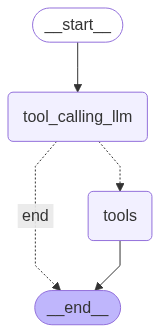

In [20]:
def tool_calling_llm(state:state):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}
#Nodes
graph_builder.add_node("tool_calling_llm",tool_calling_llm)
graph_builder.add_node("tools",ToolNode(tools))

#edges
graph_builder.add_edge(START,"tool_calling_llm")
def my_tools_condition(state):
    """Custom tools condition that checks for tool calls"""
    messages = state.get("messages", [])
    if not messages:
        return "end"
    
    last_message = messages[-1]
    
    # Check if the last message has tool calls
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    else:
        return "end"

# Use your custom function
graph_builder.add_conditional_edges(
    "tool_calling_llm",
    my_tools_condition,
    {
        "tools": "tools",
        "end": END
    }
)
graph_builder.add_edge("tools",END)
graphs=graph_builder.compile()
graphs

In [21]:
from langchain_core.messages import HumanMessage

# ✅ This will work
result = graphs.invoke({"messages":"what is today news"})
result["messages"][-1].content

'{"query": "today news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.euronews.com/2025/06/28/biden-harris-and-walz-attend-funeral-for-former-minnesota-house-speaker-melissa-hortman", "title": "Biden, Harris and Walz attend funeral for former Minnesota House Speaker Melissa Hortman - Euronews.com", "score": 0.5192538, "published_date": "Sat, 28 Jun 2025 21:27:46 GMT", "content": "Top News Stories TodayImage 3: Latest news bulletin | June 29th – EveningLatest news bulletin | June 29th – EveningEurope NewsImage 4: Pro-EU demonstration during the Romanian presidential election campaign, 2025.European flag celebrates 40 years as symbol for EU and predecessorTech NewsImage 5: stock photoExtremism and video games: How extremist groups are grooming childrenTravel NewsImage 6: Rijeka, CroatiaPKP launches night train from Warsaw to Croatian coast\\n\\n   Europe [...] Live\\n\\nClose menu sidebar \\n\\n- [x]  English  \\n   English\\n   Français\\n 

In [22]:
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is today news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (dmmanwpmb)
 Call ID: dmmanwpmb
  Args:
    query: today news
    search_depth: advanced
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "today news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.euronews.com/2025/06/28/biden-harris-and-walz-attend-funeral-for-former-minnesota-house-speaker-melissa-hortman", "title": "Biden, Harris and Walz attend funeral for former Minnesota House Speaker Melissa Hortman - Euronews.com", "score": 0.5192538, "published_date": "Sat, 28 Jun 2025 21:27:46 GMT", "content": "Top News Stories TodayImage 3: Latest news bulletin | June 29th – EveningLatest news bulletin | June 29th – EveningEurope NewsImage 4: Pro-EU demonstratio

In [23]:
from langchain_core.messages import HumanMessage

result = graphs.invoke({
    "messages": [HumanMessage(content="what is 2 + 3")]
})

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is 2 + 3
================================== Ai Message ==================================
Tool Calls:
  my_func (dm2q0vb71)
 Call ID: dm2q0vb71
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: my_func

5
